In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
dataset = pd.read_csv('../data/dataset.csv')
print(dataset)

# Define covariates, treatment, and outcome
covariate_cols = ['S3', 'C1', 'C2', 'C3', 'XC', 'X1', 'X2', 'X3', 'X4', 'X5']
treatment_col = 'Z'
outcome_col = 'Y'

# Split the data into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)

# Standardize the covariates
scaler = StandardScaler()
train_data[covariate_cols] = scaler.fit_transform(train_data[covariate_cols])
test_data[covariate_cols] = scaler.transform(test_data[covariate_cols])

       schoolid  Z         Y  S3  C1  C2  C3  XC        X1        X2  \
0            76  1  0.081602   6   4   2   1   4  0.334544  0.648586   
1            76  1 -0.385869   4  12   2   1   4  0.334544  0.648586   
2            76  1  0.398184   6   4   2   0   4  0.334544  0.648586   
3            76  1 -0.175037   6   4   2   0   4  0.334544  0.648586   
4            76  1  0.884583   6   4   1   0   4  0.334544  0.648586   
...         ... ..       ...  ..  ..  ..  ..  ..       ...       ...   
10386         1  0  0.423366   7   4   2   1   3  1.185986 -1.129889   
10387         1  0 -0.197092   7   4   2   1   3  1.185986 -1.129889   
10388         1  0  0.141698   2  15   1   1   3  1.185986 -1.129889   
10389         1  0 -0.351565   5   4   1   1   3  1.185986 -1.129889   
10390         1  0  0.211240   5   1   2   1   3  1.185986 -1.129889   

             X3        X4        X5  
0     -1.310927  0.224077 -0.426757  
1     -1.310927  0.224077 -0.426757  
2     -1.310927  0.22

<ipython-input-1-58d817bc3b44>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[covariate_cols] = scaler.fit_transform(train_data[covariate_cols])
C:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-1-58d817bc3b44>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [2]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

def s_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an S-learner model to estimate CATE.
    """
    X = data[covariate_cols + [treatment_col]]
    y = data[outcome_col]
    model.fit(X, y)
    return model

def t_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train a T-learner model to estimate CATE.
    """
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]
    X_treated = treated[covariate_cols]
    y_treated = treated[outcome_col]
    X_control = control[covariate_cols]
    y_control = control[outcome_col]
    model_treated = model.fit(X_treated, y_treated)
    model_control = model.fit(X_control, y_control)
    return model_treated, model_control

def x_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an X-learner model to estimate CATE.
    """
    treated = data[data[treatment_col] == 1]
    control = data[data[treatment_col] == 0]
    X_treated = treated[covariate_cols]
    y_treated = treated[outcome_col]
    X_control = control[covariate_cols]
    y_control = control[outcome_col]
    model_treated = model.fit(X_treated, y_treated)
    model_control = model.fit(X_control, y_control)
    treated_outcome = model_control.predict(X_treated)
    control_outcome = model_treated.predict(X_control)
    treatment_effect_treated = y_treated - treated_outcome
    treatment_effect_control = control_outcome - y_control
    model_treatment_effect_treated = model.fit(X_treated, treatment_effect_treated)
    model_treatment_effect_control = model.fit(X_control, treatment_effect_control)
    return model_treatment_effect_treated, model_treatment_effect_control

def r_learner(data, treatment_col, outcome_col, covariate_cols, model):
    """
    Train an R-learner model to estimate CATE.
    """
    X = data[covariate_cols]
    T = data[treatment_col]
    y = data[outcome_col]
    y_model = model
    y_model.fit(X, y)
    t_model = model
    t_model.fit(X, T)
    y_residual = y - y_model.predict(X)
    t_residual = T - t_model.predict(X)
    t_residual_clipped = t_residual.clip(lower=0.01)
    y_residual = (y_residual - np.mean(y_residual)) / np.std(y_residual)
    t_residual_clipped = (t_residual_clipped - np.mean(t_residual_clipped)) / np.std(t_residual_clipped)
    epsilon = 1e-3 * np.std(t_residual)
    t_residual_regularized = t_residual + epsilon
    tau_model = Ridge(alpha=1.0)
    tau_model.fit(X, y_residual / t_residual_regularized)
    return tau_model, y_model, t_model, y_residual, t_residual

In [3]:
from sklearn.metrics import mean_squared_error

def evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, model, meta_learner):
    X_test = test_data[covariate_cols + [treatment_col]]
    y_test = test_data[outcome_col]
    if meta_learner == 's':
        predictions = model.predict(X_test)
    elif meta_learner == 't':
        treated, control = model
        predictions_treated = treated.predict(test_data[test_data[treatment_col] == 1][covariate_cols])
        predictions_control = control.predict(test_data[test_data[treatment_col] == 0][covariate_cols])
        predictions = pd.concat([pd.Series(predictions_treated), pd.Series(predictions_control)], ignore_index=True)
    elif meta_learner == 'x':
        treated, control = model
        predictions_treated = treated.predict(test_data[test_data[treatment_col] == 1][covariate_cols])
        predictions_control = control.predict(test_data[test_data[treatment_col] == 0][covariate_cols])
        predictions = pd.concat([pd.Series(predictions_treated), pd.Series(predictions_control)], ignore_index=True)
    elif meta_learner == 'r':
        tau_model, _, _, _, _ = model
        predictions = tau_model.predict(test_data[covariate_cols])
        print("Predictions:")
        print(pd.Series(predictions).describe())
    mse = mean_squared_error(y_test, predictions)
    return mse

models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "NeuralNetwork": MLPRegressor(random_state=42, max_iter=500),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "SVR": SVR(),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42)
}

mse_results = []

for model_name, model in models.items():
    # S-Learner
    s_model = s_learner(train_data, treatment_col, outcome_col, covariate_cols, model)
    mse_s = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, s_model, 's')
    mse_results.append({'Meta-Learner': 'S-Learner', 'Model': model_name, 'MSE': mse_s})

    # T-Learner
    t_model_treated, t_model_control = t_learner(train_data, treatment_col, outcome_col, covariate_cols, model)
    mse_t = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, (t_model_treated, t_model_control), 't')
    mse_results.append({'Meta-Learner': 'T-Learner', 'Model': model_name, 'MSE': mse_t})

    # X-Learner
    x_model_treated, x_model_control = x_learner(train_data, treatment_col, outcome_col, covariate_cols, model)
    mse_x = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, (x_model_treated, x_model_control), 'x')
    mse_results.append({'Meta-Learner': 'X-Learner', 'Model': model_name, 'MSE': mse_x})

    # R-Learner
    r_model, y_model, t_model, y_residual, t_residual = r_learner(train_data, treatment_col, outcome_col, covariate_cols, model)
    mse_r = evaluate_model(test_data, treatment_col, outcome_col, covariate_cols, (r_model, y_model, t_model, y_residual, t_residual), 'r')
    mse_results.append({'Meta-Learner': 'R-Learner', 'Model': model_name, 'MSE': mse_r})

mse_df = pd.DataFrame(mse_results)

Predictions:
count    3118.000000
mean       16.166854
std        20.010429
min       -51.392162
25%         3.447863
50%        16.459294
75%        29.417657
max        93.324460
dtype: float64
Predictions:
count    3118.000000
mean        0.543517
std         0.762515
min        -1.264156
25%         0.026834
50%         0.495407
75%         0.962990
max         3.613681
dtype: float64
Predictions:
count    3118.000000
mean        0.702051
std         1.081850
min        -2.664967
25%        -0.039218
50%         0.647886
75%         1.396607
max         4.502519
dtype: float64
Predictions:
count    3118.000000
mean        0.582619
std         0.752356
min        -1.172215
25%         0.070675
50%         0.518054
75%         1.002519
max         3.604222
dtype: float64
Predictions:
count    3118.000000
mean        0.464599
std         0.744244
min        -1.358867
25%        -0.031984
50%         0.399314
75%         0.882235
max         3.430186
dtype: float64
Predictions:
count  

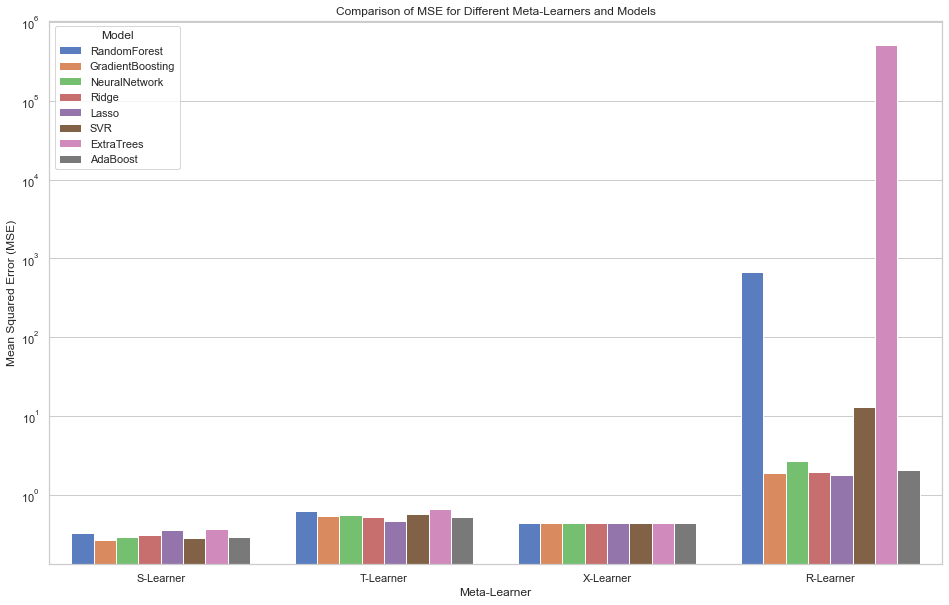

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(16, 10))
sns.barplot(x='Meta-Learner', y='MSE', hue='Model', data=mse_df, palette="muted")
plt.title('Comparison of MSE for Different Meta-Learners and Models')
plt.xlabel('Meta-Learner')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(title='Model')
plt.yscale('log')
plt.show()